# BDP Final Assignment: Twitter Education, Part 3 (Measuring Influence)

Recall

In [1]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

#import warnings
#warnings.filterwarnings(action='ignore')
#warnings.simplefilter('ignore')

In [3]:
#from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt

In [4]:
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession

GCP Tools and Functions

In [5]:
from google.cloud import storage

In [6]:
# Reading data from open bucket
# Located at my BDP-bucket
dataPath = 'gs://msca-bdp-students-bucket/shared_data/hjiang248/final_sdf_v9_formatted_2'

In [7]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
import geopandas as gpd
!pip install country_converter --upgrade
import country_converter as coco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for country_converter: filename=country_converter-0.8.0-py3-none-any.whl size=55658 sha256=f2265082a01871c0402bb1b8fe753667a8fbe13107fe7fa560def7d5aef065d0
  Stored in directory: /root/.cache/pip/wheels/9f/b5/e4/2e1e5ed6f488f5316c33caffedb734f8003c1ba829ff2a2aba
Successfully built country_converter


# Read data

In [9]:
%%time

education_DF = spark.read.parquet(dataPath)

CPU times: user 4.32 ms, sys: 4.09 ms, total: 8.41 ms
Wall time: 6.91 s


In [10]:
education_DF.printSchema()

root
 |-- date: date (nullable = true)
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- favorite_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- source_rt_usr_id: long (nullable = true)
 |-- source_rt_id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- user_description: string (nullable = true)
 |-- organization: string (nullable = true)



In [11]:
%%time
# filter tweets without location info
country = education_DF.filter((education_DF.country_code.isNotNull()) & (education_DF.country_code != 'None'))

CPU times: user 4.87 ms, sys: 111 µs, total: 4.98 ms
Wall time: 241 ms


In [12]:
country_user = country.select(['country', 'user_id'])

country_user_count = country_user.groupBy(['country']).agg(count('user_id').alias('user number'))
country_user_count = country_user_count.orderBy('user number', ascending=False).limit(10)
country_user_count

country,user number
United States,34226
United Kingdom,4038
India,2299
Canada,1364
Nigeria,969
Australia,651
South Africa,418
Kingdom of Saudi ...,417
Ireland,390
Pakistan,358


Dataframe worldwide

In [13]:
# choose columns
country = country.select(['country_code', 'country', 'date'])

# count tweet by country and date
country_tweet = country.groupBy(['country_code']).count().orderBy('count', ascending=False)

# convert to Pandas
country_pd = country_tweet.toPandas()

In [14]:
# filter tweets without location info
USA = education_DF.filter((education_DF.country_code.isNotNull()) & (education_DF.country_code == 'US'))
USA = USA.select(['location', 'id'])

# count tweet by country and date
USA = USA.groupBy(['location']).count().orderBy('count', ascending=False)

Prepare a tweet dataframe within USA

Some locations are formatted as `State, ABBR` such as `Chicago, IL`; however, some other locations have a format of `State, USA` such as `Texas, USA`. We need to fix this by converting all of them to state abbreviation.

In [15]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

keys = list(us_state_to_abbrev.keys())

In [16]:
from pyspark.sql.functions import split
from pyspark.sql.types import StringType

In [17]:

# define a udf function
@F.udf(returnType=StringType())
def convert_state_abbr(name):
    if name in keys:
        return us_state_to_abbrev[name]
    else:
        return 'unknown'


# first extract either State full name or State abbreviation
USA = USA.filter(USA.location.contains(', ')) \
         .withColumn('STATE_ABBR', F.when((~USA.location.contains('USA')), split(USA.location, ', ').getItem(1)) \
                                    .when((USA.location.contains('USA')), convert_state_abbr(split(USA.location, ', ').getItem(0))) \
                                    .otherwise('unknown'))

In [18]:
#USA.limit(10)
#USA.groupBy('STATE_ABBR').agg(sum('count').alias('tweet_count')).orderBy('tweet_count', ascending=False)

In [19]:
%%time
# check the length of state abbreviation
USA_pd = USA.groupBy('STATE_ABBR').agg(sum('count').alias('count')).orderBy('count', ascending=False).toPandas()

USA_pd.head(10)

CPU times: user 28.5 ms, sys: 4.06 ms, total: 32.5 ms
Wall time: 4.06 s


,STATE_ABBR,count
0,TX,4534
1,CA,3402
2,FL,2882
3,NY,1683
4,NC,1431
5,GA,1188
6,MI,1027
7,PA,1013
8,OH,964
9,VA,956


# Data Prepartion

1. convert country code from ISO2 to ISO3 (ref: https://pypi.org/project/country-converter/)

In [20]:
%%time

country_pd['iso_a3'] = country_pd['country_code'].map(lambda x: coco.convert(x, to='ISO3'))

 not found in regex


CPU times: user 17 s, sys: 76.8 ms, total: 17.1 s
Wall time: 17 s


In [21]:
country_pd.head(15)

,country_code,count,iso_a3
0,US,34298,USA
1,GB,4048,GBR
2,IN,2335,IND
3,CA,1367,CAN
4,NG,969,NGA
5,AU,651,AUS
6,SA,497,SAU
7,ZA,418,ZAF
8,IE,395,IRL
9,PK,360,PAK


# Plot

## Tweets Count by World

In [22]:
# import world from geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# drop un-needed columns
world = world.drop(columns=['pop_est', 'gdp_md_est'])

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [23]:
# merge dataframe
world_tweet = world.merge(country_pd, on='iso_a3', how='left')

# fill na values
world_tweet['tweet_count'] = world_tweet['count'].fillna(0).astype(int)

Text(154.92172419641, 0.5, 'Longitude')

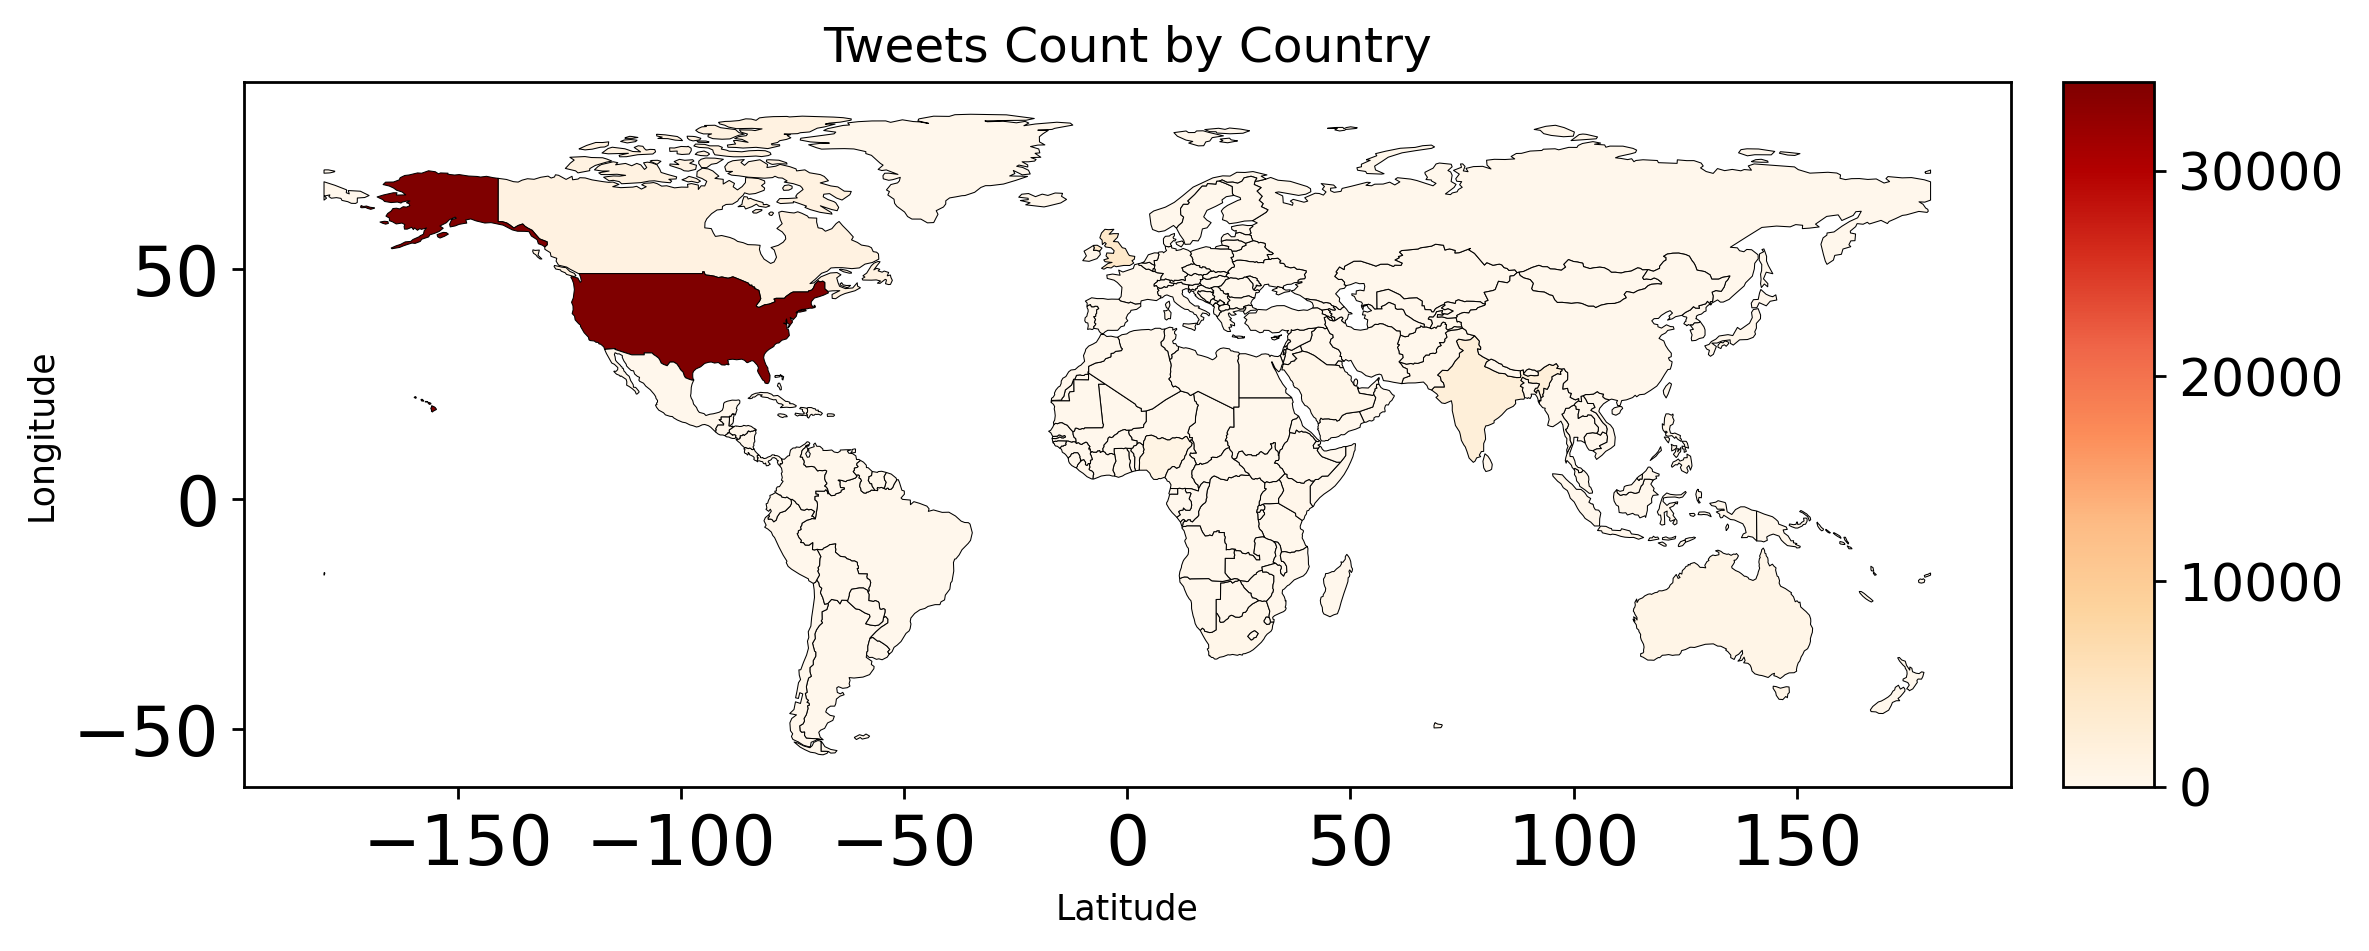

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 15})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world_tweet_tomap = world_tweet[(world_tweet['tweet_count'] >= 0) & (world_tweet.name!="Antarctica")]

world_tweet_tomap.plot(column='tweet_count', ax=ax, 
                       legend=True, cmap='OrRd', cax=cax, edgecolor='black', linewidth=0.3)

ax.set_title('Tweets Count by Country', fontsize=14)
ax.set_xlabel('Latitude', fontsize=10)
ax.set_ylabel('Longitude', fontsize=10)


Text(148.23811822889624, 0.5, 'Longitude')

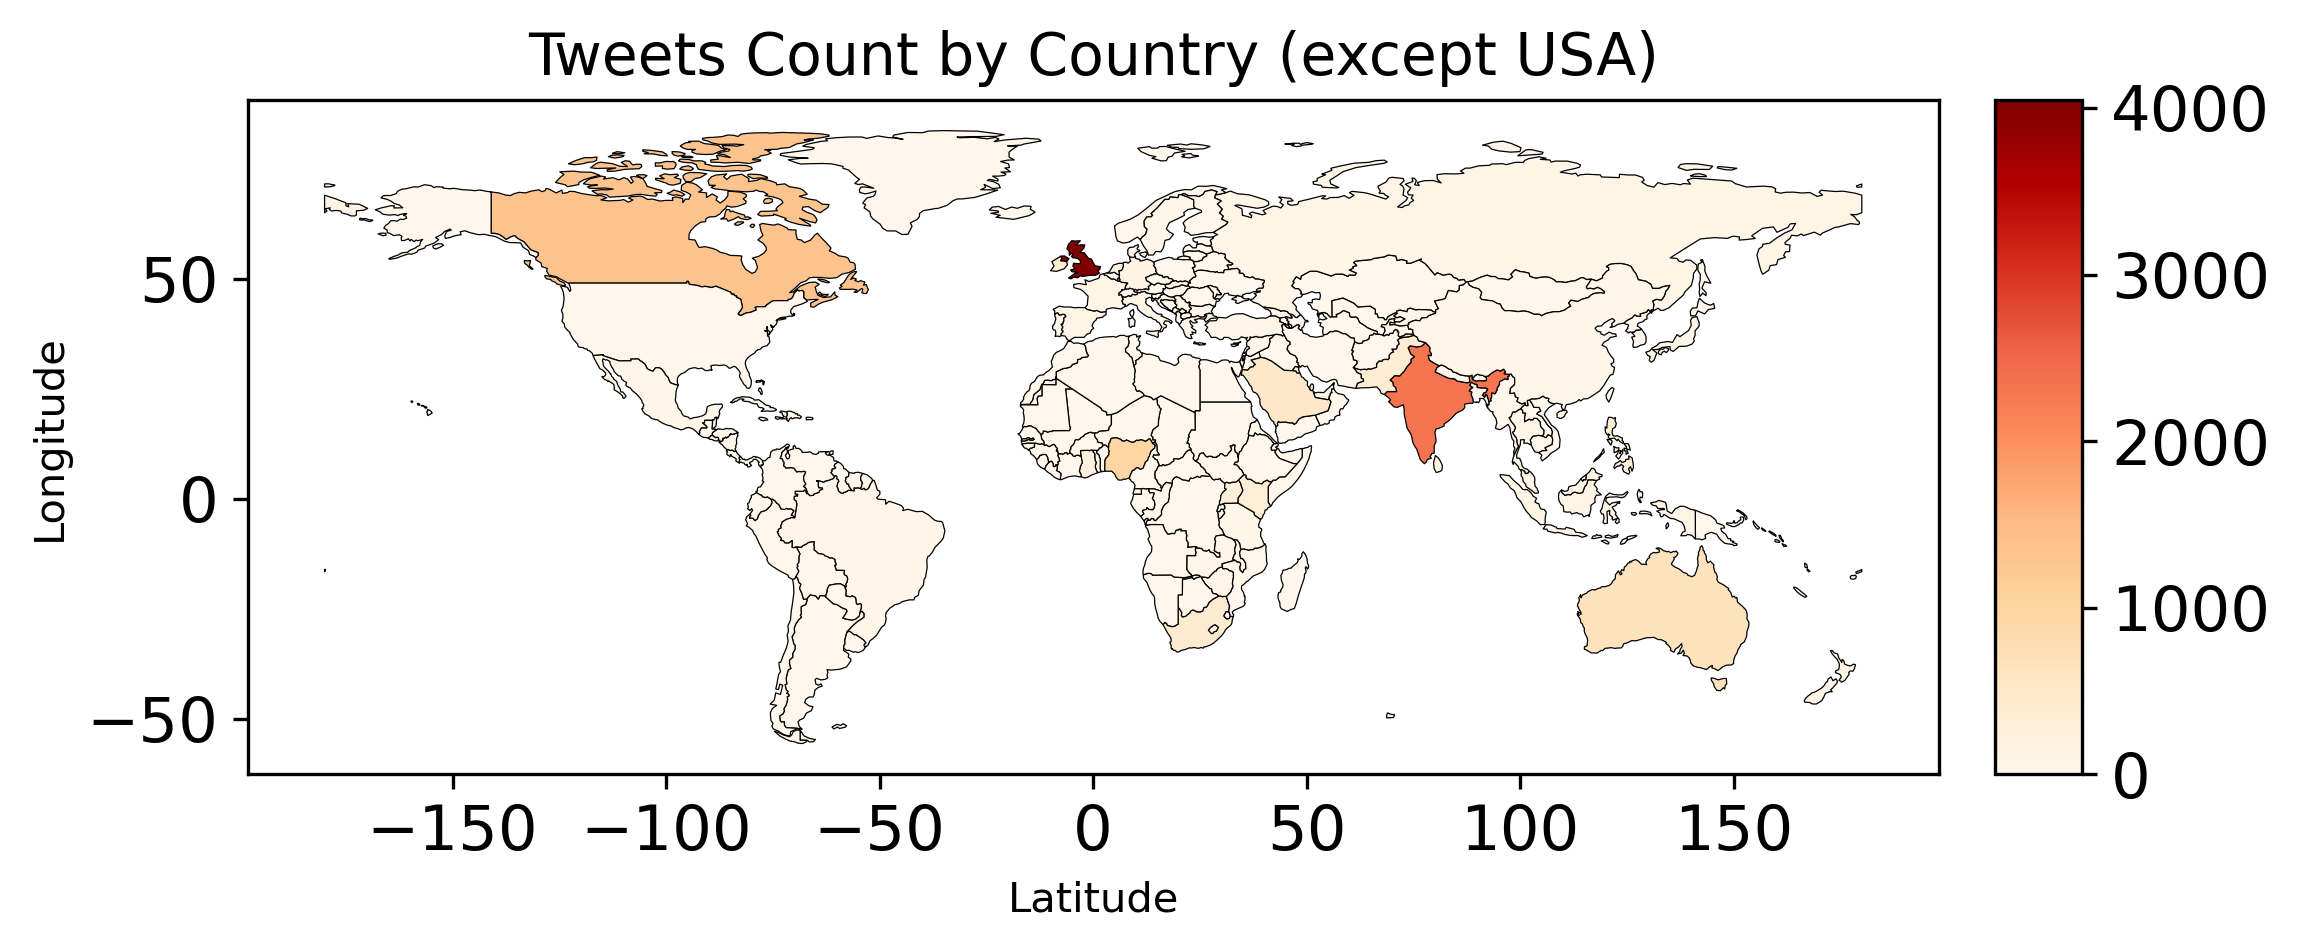

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 15})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world_tweet_2 = world_tweet.copy(deep=True)

#change value of USA
world_tweet_2.iloc[4, 6] = 0

world_tweet_tomap2 = world_tweet_2[(world_tweet_2['tweet_count'] >= 0) & (world_tweet_2.name!="Antarctica")]

world_tweet_tomap2.plot(column='tweet_count', ax=ax, 
                       legend=True, cmap='OrRd', cax=cax, edgecolor='black', linewidth=0.3)

ax.set_title('Tweets Count by Country (except USA)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=10)
ax.set_ylabel('Longitude', fontsize=10)


## Tweets Count in USA

In [26]:
USA_gpd = gpd.read_file('gs://msca-bdp-students-bucket/shared_data/hjiang248/states_21basic')

In [27]:
#usa.columns

In [28]:
usa_tweet = USA_gpd.drop(columns=['DRAWSEQ', 'STATE_FIPS', 'SUB_REGION'])

In [29]:
# merge dataframe
usa_tweet = usa_tweet.merge(USA_pd, on='STATE_ABBR', how='left')

# fill na values
usa_tweet['tweet_count'] = usa_tweet['count'].fillna(0).astype(int)

Text(351.64589784630095, 0.5, 'Longitude')

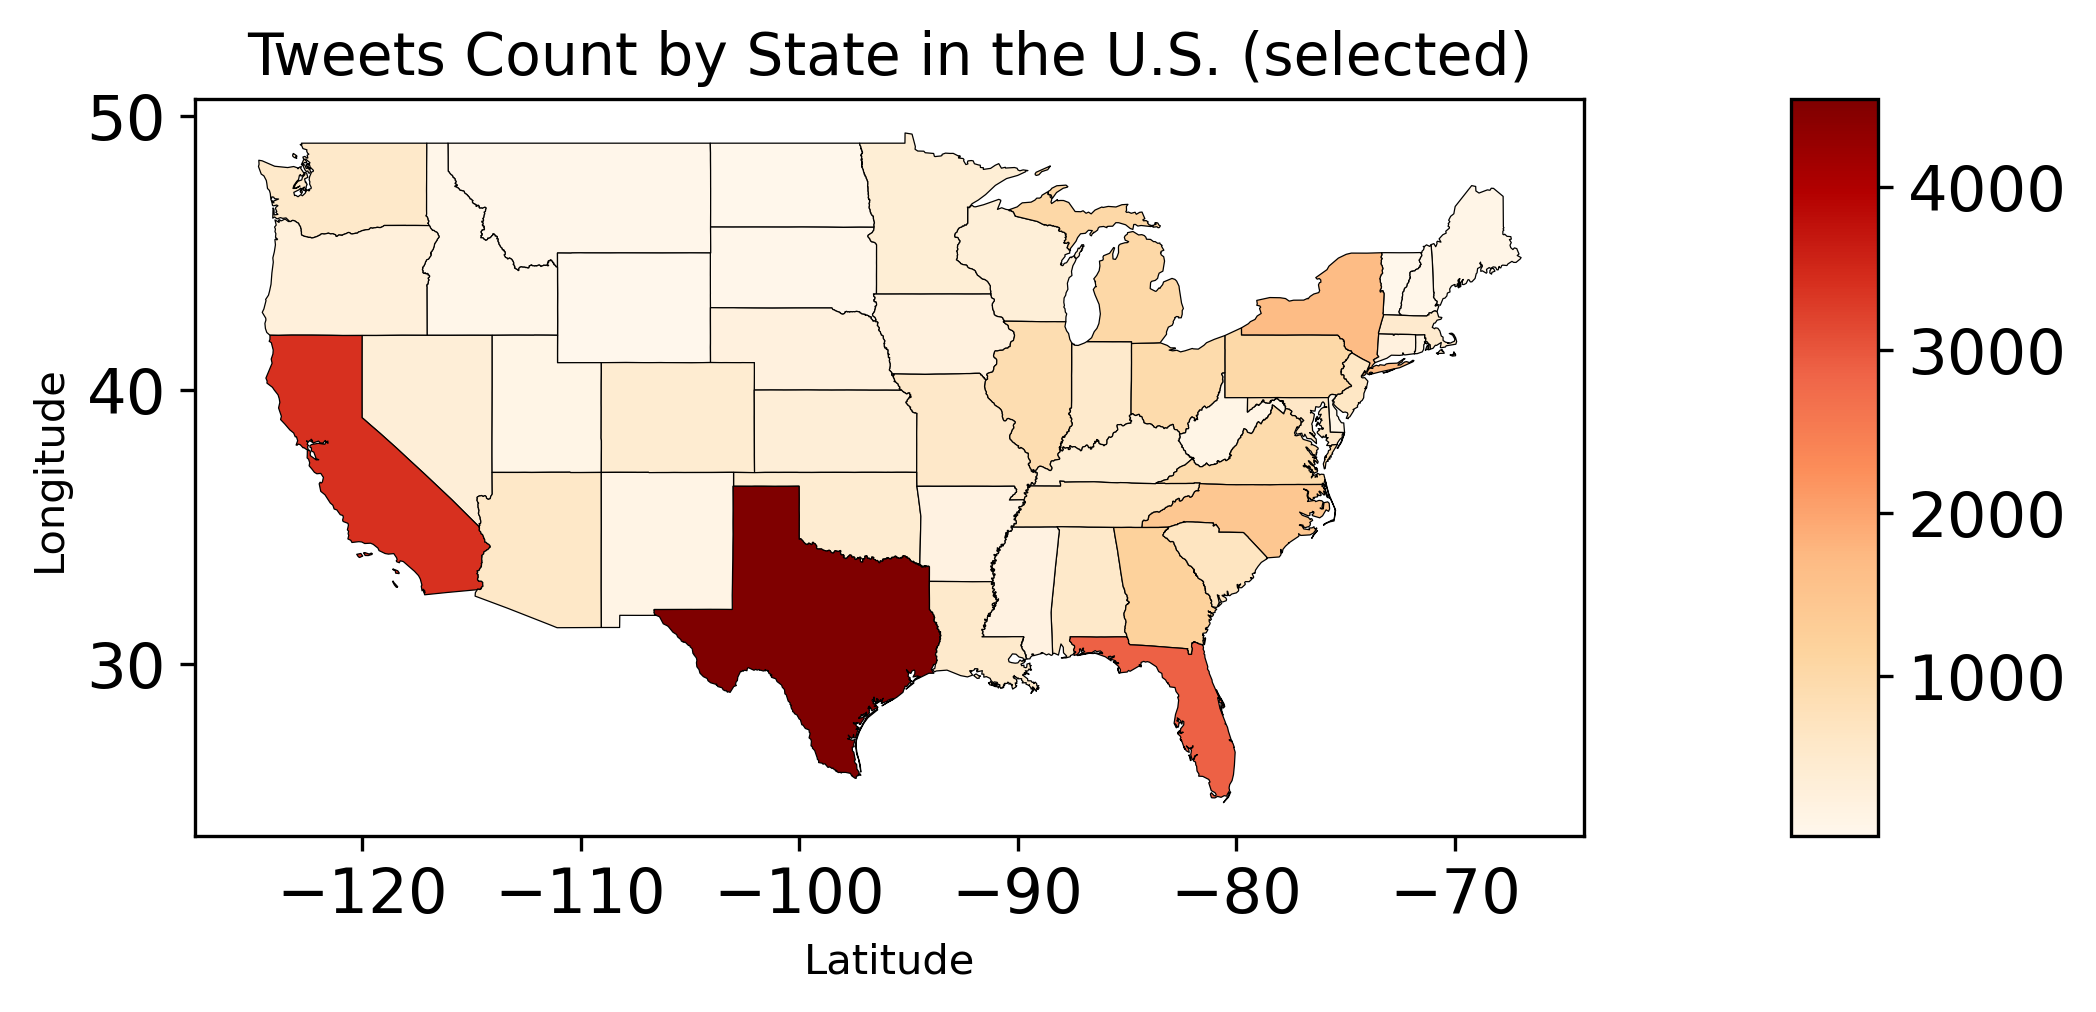

In [30]:
fig, ax = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 15})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

usa_tweet_tomap = usa_tweet[(usa_tweet['tweet_count'] > 0) & (usa_tweet.STATE_ABBR != 'AK') & (usa_tweet.STATE_ABBR != 'HI')]

usa_tweet_tomap.plot(column='tweet_count', ax=ax, 
                     legend=True, cmap='OrRd', cax=cax, edgecolor='black', linewidth=0.3)

ax.set_title('Tweets Count by State in the U.S. (selected)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=10)
ax.set_ylabel('Longitude', fontsize=10)


In [31]:
usa_tweet_tomap['tweet_count'].describe()

count      49.000000
mean      650.244898
std       866.850947
min        16.000000
25%       144.000000
50%       379.000000
75%       669.000000
max      4534.000000
Name: tweet_count, dtype: float64

# Trends and User Number

In [32]:
%%time

# filter tweets without location info
country = education_DF.filter((education_DF.country_code.isNotNull()) & (education_DF.country_code != 'None'))
country = country.select(['country_code', 'country', 'date'])

# count tweet by country and date
country_tweet_day = country.groupBy(['country_code', 'date']).count().orderBy('count', ascending=False)

# convert to Pandas
country_pd_day = country_tweet_day.toPandas()

CPU times: user 167 ms, sys: 20.7 ms, total: 187 ms
Wall time: 2.83 s


In [33]:
country_pd_day.sort_values(by='date', ascending=False)

,country_code,date,count
1724,GH,2022-11-06,2
530,IN,2022-11-06,10
4151,AU,2022-11-06,1
214,US,2022-11-06,85
1857,PH,2022-11-06,2
...,...,...,...
798,IN,2022-04-05,6
4044,KE,2022-04-05,1
3204,GH,2022-04-05,1
4539,CH,2022-04-05,1


In [34]:
country_pd_top10 = country_pd_day[country_pd_day['country_code'].str.contains('US') |\
                                  country_pd_day['country_code'].str.contains('GB') |\
                                  country_pd_day['country_code'].str.contains('IN') |\
                                  country_pd_day['country_code'].str.contains('CA') |\
                                  country_pd_day['country_code'].str.contains('NG') |\
                                  country_pd_day['country_code'].str.contains('AU') ]

In [35]:
#country_pd_top10['date_dt'] = pd.to_datetime(country_pd_top10['date'], format='%Y-%m-%d')
country_pd_top10['date'] = pd.to_datetime(country_pd_top10['date'], format='%Y-%m-%d')
#country_pd_top10['month'] = country_pd_top10.date.dt.month
#country_pd_top10 = country_pd_top10.set_index('date_dt')

/tmp/ipykernel_11230/793500143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_pd_top10['date'] = pd.to_datetime(country_pd_top10['date'], format='%Y-%m-%d')


In [36]:
country_pd_top10.head(5)

,country_code,date,count
0,US,2022-05-25,324
1,US,2022-11-03,299
2,US,2022-05-03,283
3,US,2022-08-25,280
4,US,2022-05-02,272


In [37]:
#country_pd_top10_sliced = country_pd_top10.loc['2022-10']
#country_pd_top10_sliced = country_pd_top10[country_pd_top10['country_code'] != 'US']

In [38]:
#output = country_pd_top10.groupby(['month', 'country_code']).sum('count')
#dataFrame.groupby(pd.Grouper(key='Date_of_Purchase', axis=0, freq='M')).sum()
output = country_pd_top10.groupby([pd.Grouper(key='date', axis=0, freq='M'), 'country_code']).sum('count').unstack()

In [39]:
output

count                          
country_code    AU   CA   GB   IN   NG    US
date                                        
2022-04-30      74  134  372  285  125  3638
2022-05-31     101  185  594  299  112  5749
2022-06-30     105  175  620  258  138  4366
2022-07-31      83  123  637  367  103  4532
2022-08-31      90  180  492  328  130  6383
2022-09-30      81  270  650  497  140  4444
2022-10-31     102  232  588  263  197  4255
2022-11-30      15   68   95   38   24   931

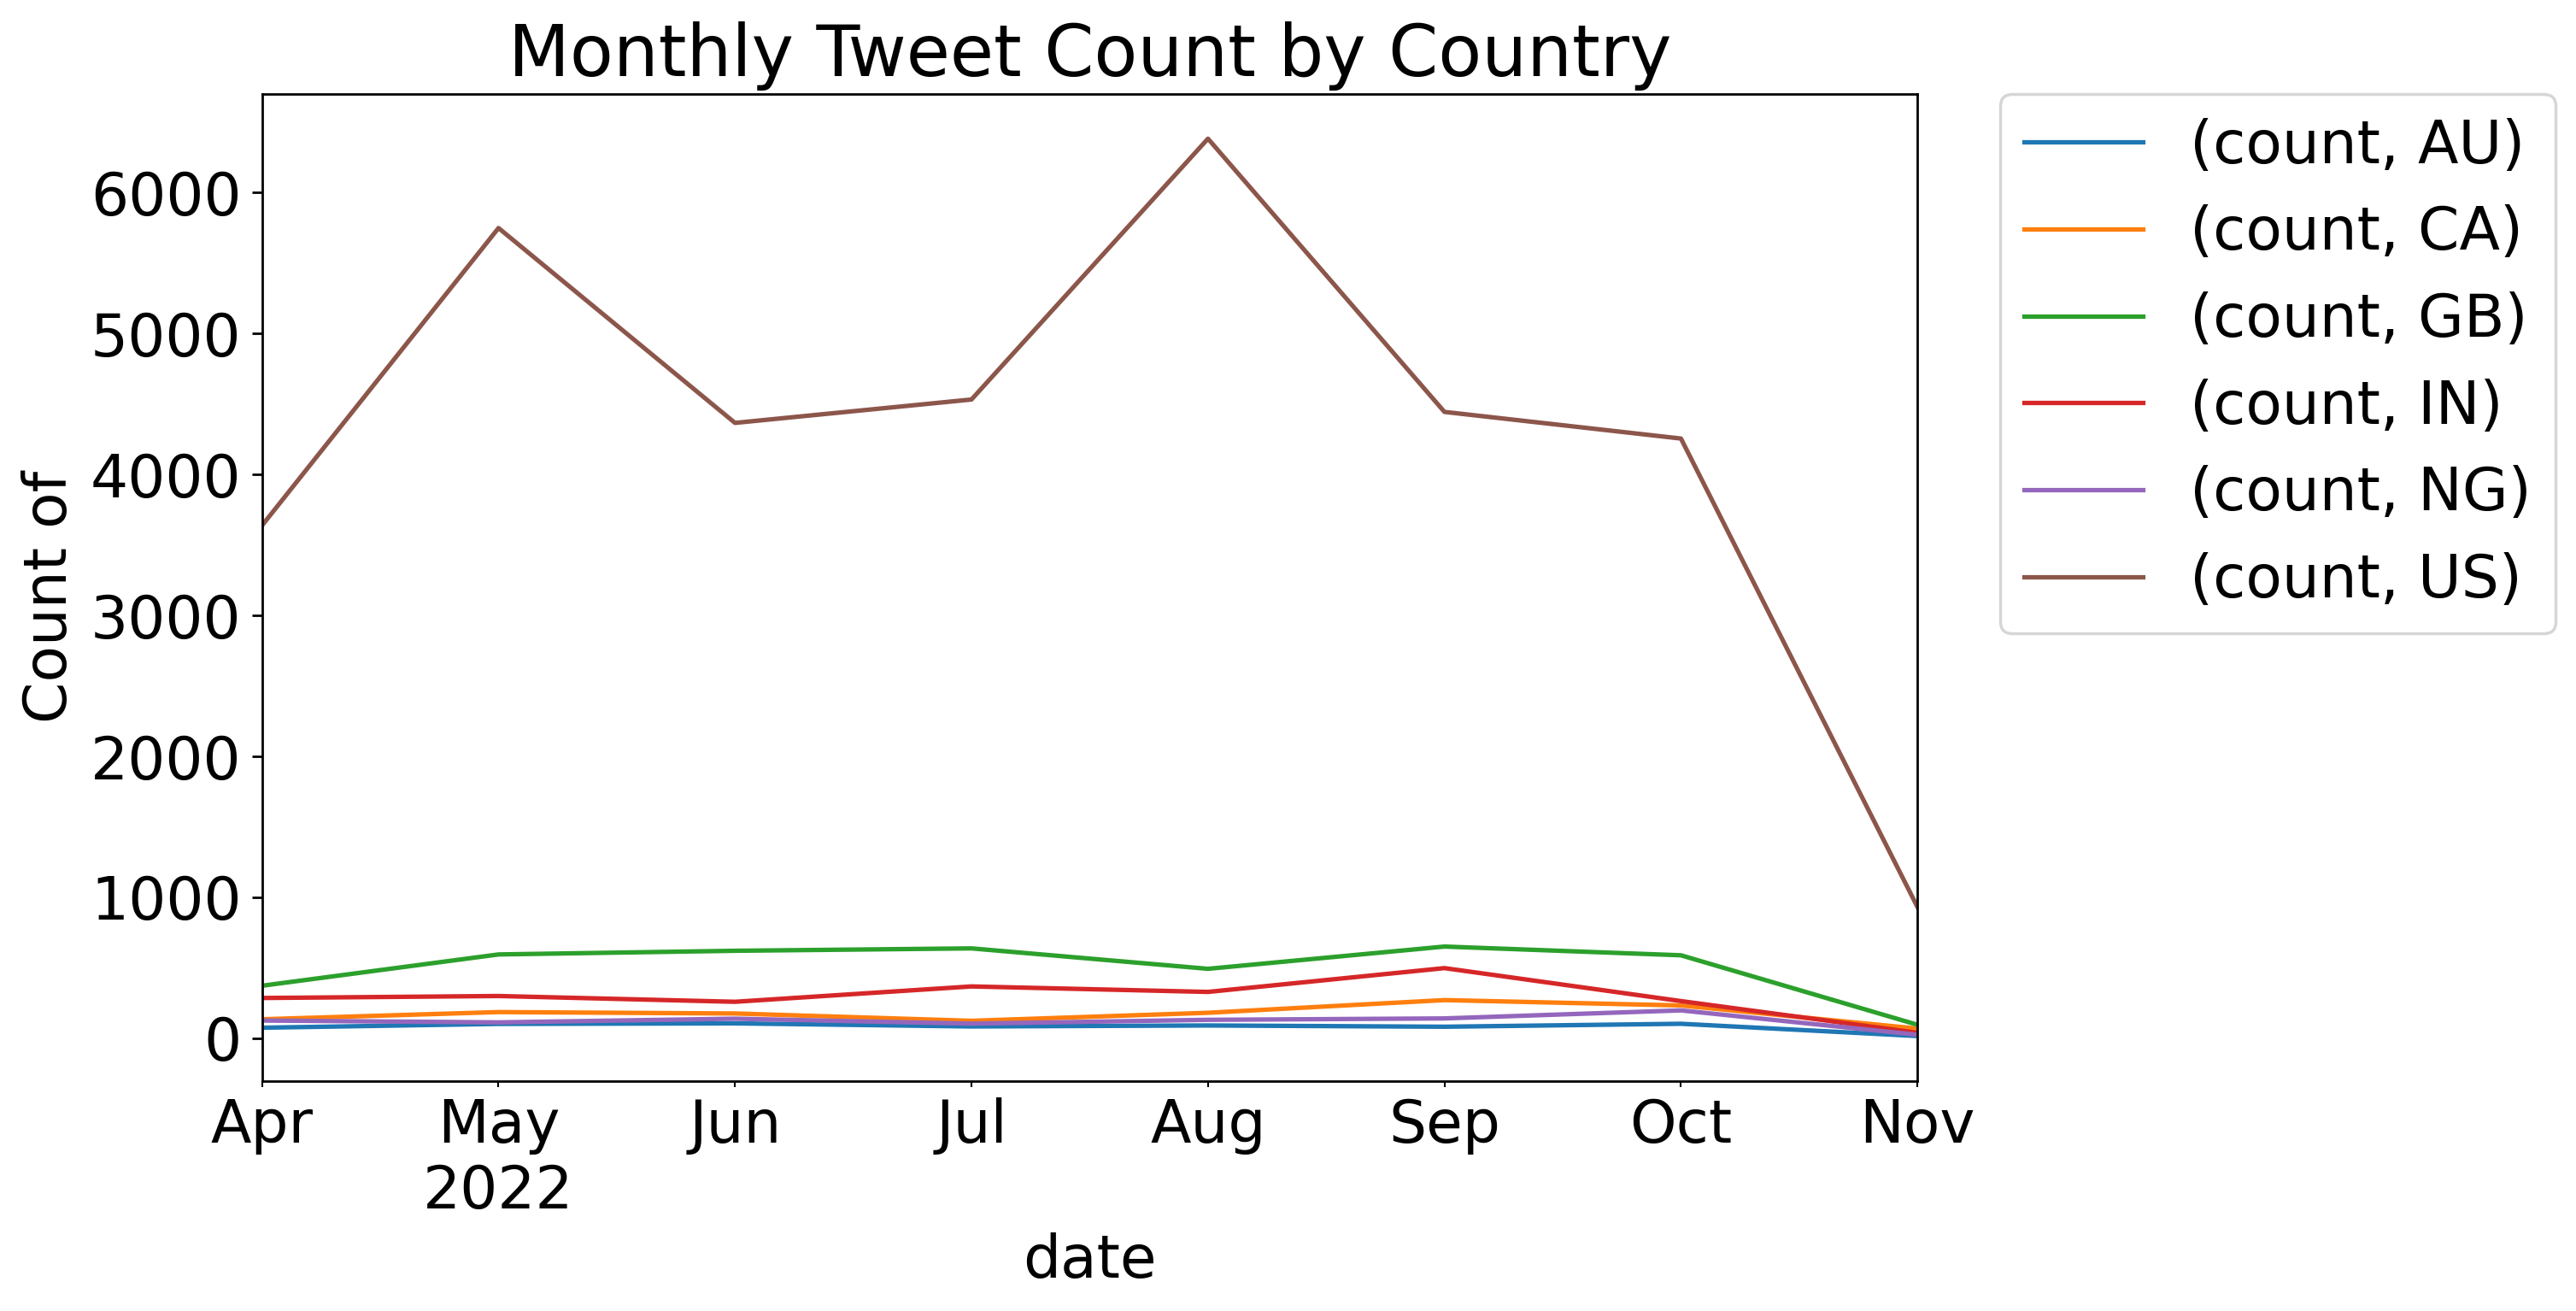

In [40]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 250
plt.rcParams.update({'font.size': 20})

output.plot(title='Monthly Tweet Count by Country', ylabel='Count of ')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()